In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import os

## start - single disease

In [ ]:
year_cut = 2019
score_cut = 0.4

### PPI names to id

In [2]:
year = '2019'
full = True

In [3]:
import pickle
with open('/itf-fi-ml/shared/users/ziyuzh/svm/data/stringdb/2023/name_convert.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
stringId2name,name2stringId,aliases2stringId = loaded_data

In [ ]:
# local_stringdb = os.path.join('data/stringdb',year)

# ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.info.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
# ppidf['preferred_name'] = ppidf['preferred_name'].str.upper()
# stringId2name = ppidf.set_index('#string_protein_id')['preferred_name'].to_dict()
# name2stringId = ppidf.set_index('preferred_name')['#string_protein_id'].to_dict()
# ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.aliases.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
# ppidf['alias'] = ppidf['alias'].str.upper()
# aliases2stringId = ppidf.set_index('alias')['#string_protein_id'].to_dict()

### read

In [5]:
df = pd.read_csv('data/dga_data.csv')
df['first_pub_year'] = df['first_pub_year'].apply(lambda x: np.nan if x in [None, "None"] else float(x))
df['last_pub_year'] = df['last_pub_year'].apply(lambda x: np.nan if x in [None, "None"] else float(x))
# filter on score
df = df[df['score'] >= score_cut]
# df['string_id'] = df['gene_id'].map(name2stringId)
# check whether we can operate time cut
if df['first_pub_year'].isna().sum()/len(df) > 0.3:
    time_cut = False
    print('only ', round(1-df['first_pub_year'].isna().sum()/len(df),2),'of associations have record publiacation year')

# split train and test genes
if time_cut:
    print('year cut is ', year_cut)
    df.dropna(subset='first_pub_year')
    train_genes = df[df['first_pub_year']>= year_cut]['gene_id']
    test_genes = df[df['first_pub_year']< year_cut]['gene_id']
else:
    print('no sufficient information, random split')
    pos_genes_ori = df['string_id']
    # df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    # train_size = int(0.8 * len(df))  # Calculate 80% index
    # train_genes = df['gene_id'][:train_size]  # First 80%
    # test_genes = df['gene_id'][train_size:]

only  0.07 of associations have record publiacation year
no sufficient information, random split


KeyError: 'string_id'

In [46]:
all_df = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/disgenet_string.csv')
df = all_df[all_df['disease_id']=='ICD10_G20']
pos_genes_ori = df['string_id']

In [47]:
df

,disease_id,omim,hpo,disease_name,gene_id,score,first_pub_year,last_pub_year,ei,dsi,dpi,uniprot_id,string_id
4810,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,SNCA,1.0,1989.0,2021.0,0.961,0.317,0.957,P37840,9606.ENSP00000500990
4811,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,LRRK2,1.0,1993.0,2021.0,0.938,0.473,0.870,Q5S007,9606.ENSP00000298910
4812,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,PRKN,1.0,1998.0,2022.0,0.931,0.405,0.913,O60260,9606.ENSP00000355865
4813,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,GBA1,1.0,1987.0,2021.0,0.936,0.432,0.913,P04062,9606.ENSP00000314508
4814,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,PINK1,1.0,2004.0,2022.0,0.951,0.471,0.913,Q9BXM7,9606.ENSP00000364204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4951,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,RPL6,0.4,2008.0,2008.0,1.000,0.700,0.609,Q02878,9606.ENSP00000403172
4952,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,RPL23A,0.4,2008.0,2008.0,1.000,0.793,0.304,P62750,9606.ENSP00000389103
4953,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,SLC38A2,0.4,2022.0,2022.0,1.000,0.664,0.652,Q96QD8,9606.ENSP00000256689
4954,ICD10_G20,OMIM_516000,NaN,Parkinson Disease,KCNJ4,0.4,2008.0,2008.0,1.000,0.713,0.478,P48050,9606.ENSP00000306497


## publication year
None in DisGeNET is because the association collected from existing database without references

In [ ]:
import requests

def get_earliest_pubmed_pmid_and_year(gene, disease):
    # Construct the search query
    query = f"{gene} AND {disease}"
    
    # PubMed URL to get the total number of results
    search_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmode=json&sort=pub+date"
    
    try:
        # Fetch search results to get the total count
        response = requests.get(search_url)
        response.raise_for_status()
        total_results = int(response.json().get("esearchresult", {}).get("count", 0))

        if total_results == 0:
            print("No results found for the given query.")
            return None

        # Fetch only the last result (earliest publication)
        earliest_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retstart={total_results - 1}&retmax=1&retmode=json&sort=pub+date"
        earliest_response = requests.get(earliest_url)
        earliest_response.raise_for_status()
        pmid = earliest_response.json().get("esearchresult", {}).get("idlist", [])[0]

        # Fetch the publication year for the earliest publication
        summary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={pmid}&retmode=json"
        summary_response = requests.get(summary_url)
        summary_response.raise_for_status()
        pub_year = summary_response.json()["result"][pmid]["pubdate"].split()[0]  # Extract the year

        return pmid, pub_year

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
gene = "IFNG"
disease = "Breast Cancer"
result = get_earliest_pubmed_pmid_and_year(gene, disease)

# Print the earliest publication PMID and year
if result:
    pmid, pub_year = result
    print(f"PMID: {pmid}\nPublication Year: {pub_year}")


## PPI features

### ppi connections

In [5]:
local_stringdb = os.path.join('/itf-fi-ml/shared/users/ziyuzh/svm/data/stringdb',year)

if full:
    # ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.links.v12.0.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
    # ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.links.v10.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
    ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.links.v10.5.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))

    # ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.links.v9.1.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))

else:
    ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.physical.links.full.v12.0.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))

ppi_connection[['protein1', 'protein2']] = np.sort(ppi_connection[['protein1', 'protein2']], axis=1)
ppi_connection = ppi_connection.drop_duplicates()
ppi_connection

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000263431,260
1,9606.ENSP00000000233,9606.ENSP00000353863,164
2,9606.ENSP00000000233,9606.ENSP00000342026,159
3,9606.ENSP00000000233,9606.ENSP00000240874,194
4,9606.ENSP00000000233,9606.ENSP00000379847,164
...,...,...,...
11343551,9606.ENSP00000473005,9606.ENSP00000473172,503
11345266,9606.ENSP00000473036,9606.ENSP00000473233,510
11346676,9606.ENSP00000473043,9606.ENSP00000473233,157
11347900,9606.ENSP00000473166,9606.ENSP00000473233,157


In [11]:
import pandas as pd
import networkx as nx

# Convert to NetworkX graph
G = nx.from_pandas_edgelist(ppi_connection, 'protein1', 'protein2')

# Get number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")


Number of nodes: 20770
Number of edges: 2425314


In [13]:
1- 2425314*2/(20770*(20770-1))

0.9887553514409937

In [14]:
1- 6/(20770-1)

0.9997111079011989

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

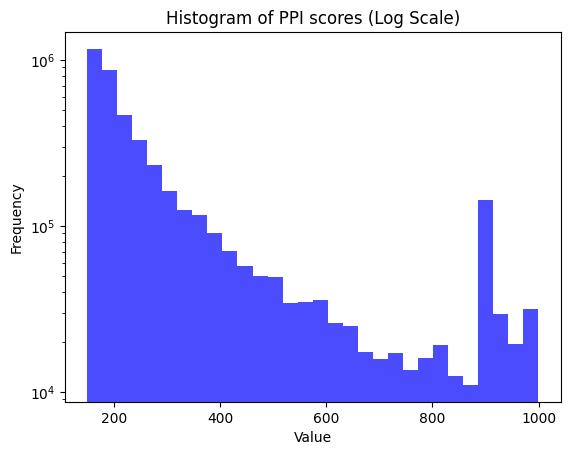

In [13]:
# Plot a histogram with a logarithmic y-axis
plt.hist(ppi_connection['combined_score'], bins=30, alpha=0.7, color='blue')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Label the axes and give the histogram a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of PPI scores (Log Scale)')

# Show the plot
plt.show()

In [7]:
ppi_connection[['protein1', 'protein2']].to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/ppi_full_2019.txt', sep='\t', index=False, header=False)

In [6]:
ppi_connection = ppi_connection[ppi_connection['combined_score']>=700]
ppi_connection[['protein1', 'protein2']].to_csv('data/ppi_full_2016_700.txt', sep='\t', index=False, header=False)

### ppi embs

In [8]:
### PPI features from node2vec
from pecanpy import pecanpy as node2vec

def Runnode2vec(filepath):
    n2v = node2vec.SparseOTF(p=1, q=1, workers=4, verbose=True)

    edge_list = n2v.read_edg(filepath, weighted=False, directed=False)
    emd = n2v.embed(dim=128, num_walks=10, walk_length=80, window_size=10, epochs=10)

    n2v_emd = pd.DataFrame(emd, n2v.nodes)

    n2v_emd.columns = ['network_' + str(col) for col in n2v_emd.columns]

    n2v_emd = n2v_emd.reset_index().rename(columns={"index":"string_id"})

    return n2v_emd

In [ ]:
ppi_features = Runnode2vec('/itf-fi-ml/shared/users/ziyuzh/svm/data/ppi_full_2019.txt')

new_columns = ['string_id'] + [f'feature_{i}' for i, col in enumerate(ppi_features.columns) if col != 'string_id']
# Reorder the DataFrame so that 'string_id' is the first column
df_combined = ppi_features[['string_id'] + [col for col in ppi_features.columns if col != 'string_id']]
df_combined.columns = new_columns
df_combined.to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/ppi_full_2019_emb.csv', index=False)

  0%|          | 0/195760 [00:00<?, ?it/s]

OSError: Cannot save file into a non-existent directory: 'data'

In [9]:
ppi_connection

,protein1,protein2,combined_score
23,9606.ENSP00000000233,9606.ENSP00000158762,849
99,9606.ENSP00000000233,9606.ENSP00000225567,733
141,9606.ENSP00000000233,9606.ENSP00000237596,796
166,9606.ENSP00000000233,9606.ENSP00000245541,844
219,9606.ENSP00000000233,9606.ENSP00000254584,906
...,...,...,...
8500923,9606.ENSP00000468633,9606.ENSP00000472469,900
8509028,9606.ENSP00000469716,9606.ENSP00000473005,816
8511201,9606.ENSP00000470004,9606.ENSP00000472469,999
8517812,9606.ENSP00000470609,9606.ENSP00000472469,719


In [ ]:
year = '2016'
local_stringdb = os.path.join('data/stringdb',year)

if year == '2016':
    ## file downloaded from http://version10.string-db.org/cgi/download.pl?UserId=vbivmmm5Wujk&sessionId=4QpfFTtZltdE&species_text=Homo+sapiens
    ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.links.v10.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
elif year == '2013':
    ## file downloaded from http://string91.embl.de/newstring_cgi/show_download_page.pl
    ppi_connection = pd.read_csv(os.path.join(local_stringdb,'9606.protein.links.v9.1.txt'), sep=' ', header=0).convert_dtypes().replace(0, float('nan'))
### more years' version is avaliable here: https://string-db.org/cgi/access?sessionId=bnJPTXTUY2sp&footer_active_subpage=archive

ppi_connection[['protein1', 'protein2']] = np.sort(ppi_connection[['protein1', 'protein2']], axis=1)
ppi_connection = ppi_connection.drop_duplicates()
ppi_connection = ppi_connection[ppi_connection['combined_score']>=700]
ppi_connection[['protein1', 'protein2']].to_csv('data/ppi_full_'+year+'_700.txt', sep='\t', index=False, header=False)

from pecanpy import pecanpy as node2vec
def Runnode2vec(filepath):
    n2v = node2vec.SparseOTF(p=1, q=1, workers=4, verbose=True)
    edge_list = n2v.read_edg(filepath, weighted=False, directed=False)
    emd = n2v.embed(dim=128, num_walks=10, walk_length=80, window_size=10, epochs=10)
    n2v_emd = pd.DataFrame(emd, n2v.nodes)
    n2v_emd.columns = ['network_' + str(col) for col in n2v_emd.columns]
    n2v_emd = n2v_emd.reset_index().rename(columns={"index":"string_id"})
    return n2v_emd

ppi_features = Runnode2vec('data/ppi_full_'+year+'_700.txt')
new_columns = ['string_id'] + [f'feature_{i}' for i, col in enumerate(ppi_features.columns) if col != 'string_id']
# Reorder the DataFrame so that 'string_id' is the first column
df_combined = ppi_features[['string_id'] + [col for col in ppi_features.columns if col != 'string_id']]
df_combined.columns = new_columns
df_combined.to_csv('data/ppi_full_'+year+'_700_emb.csv', index=False)


## train svm

In [14]:
from sklearn import svm
from sklearn import metrics
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid,GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

### preprocess PPI features

In [3]:
ppi_features = pd.read_csv('data/ppi_full_400_emb.csv')
ppi_features

,Unnamed: 0,string_id,network_0,network_1,network_2,network_3,network_4,network_5,network_6,network_7,...,network_118,network_119,network_120,network_121,network_122,network_123,network_124,network_125,network_126,network_127
0,0,9606.ENSP00000000233,0.223530,-0.235226,0.094986,-0.213112,-0.625754,-0.475147,0.105763,0.320114,...,-0.374826,-0.000145,0.142491,0.185772,0.072305,0.397585,0.758470,-0.203086,-0.433643,-0.112703
1,1,9606.ENSP00000493357,-0.191385,-0.353500,0.393396,-0.245849,-0.449670,-0.743239,0.463694,0.269243,...,-0.283103,0.211400,0.036084,0.008622,0.280595,0.023758,0.817476,0.124353,0.298902,0.338053
2,2,9606.ENSP00000371175,-0.401759,-0.324329,-0.027733,-0.162309,-0.251981,-0.512836,0.278952,0.293465,...,-0.032706,0.184821,0.041541,-0.193859,0.169435,0.212499,0.062882,0.463617,-0.075447,0.080985
3,3,9606.ENSP00000354878,0.387587,-0.264049,0.394575,-0.358497,-0.308870,-0.493699,0.011423,0.205499,...,-0.319141,0.087096,0.185822,0.041787,0.142429,0.403528,0.381309,-0.077168,-0.593768,0.048478
4,4,9606.ENSP00000310226,0.159782,-0.089659,0.118550,-0.313520,-0.341632,-0.395354,-0.155088,0.087368,...,-0.003687,-0.021955,0.368666,0.084444,-0.224881,0.249145,0.323018,-0.281367,-0.471454,0.027044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,19483,9606.ENSP00000490576,0.585741,0.085865,0.677294,-0.131001,-0.064755,-0.059339,0.457962,0.490656,...,-0.355362,0.758349,-0.108142,-0.568465,0.097037,-0.034515,0.690594,0.357157,-0.037189,0.134014
19484,19484,9606.ENSP00000493167,0.537724,0.505898,1.097451,0.093177,0.195258,-0.220749,0.244209,0.213965,...,-0.535035,0.478327,-0.095261,-0.844498,0.202828,-0.206135,0.686160,0.166637,0.089283,0.358458
19485,19485,9606.ENSP00000490626,0.246953,0.218115,1.277090,0.111482,-0.295725,-0.369701,0.049896,-0.008466,...,-0.470120,0.633600,-0.184238,-0.840138,-0.039470,-0.224628,0.249099,0.355921,0.362131,-0.041627
19486,19486,9606.ENSP00000490899,0.010735,-0.234669,0.438560,-0.237305,0.608167,-0.407764,-0.344675,0.580593,...,-0.113341,0.391435,0.178506,-0.095014,0.014469,0.168685,0.468479,0.409585,0.359002,0.148377


In [12]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# # Initialize MinMaxScaler
# # scaler = MinMaxScaler()
# scaler = StandardScaler()

# # Apply normalization to columns starting from the 3rd column (index 2)
# ppi_features_normalized = scaler.fit_transform(ppi_features.iloc[:, 2:])

# # Replace the normalized values back into the DataFrame
# ppi_features.iloc[:, 2:] = ppi_features_normalized
ppi_features

,Unnamed: 0,gene_id,network_0,network_1,network_2,network_3,network_4,network_5,network_6,network_7,...,network_118,network_119,network_120,network_121,network_122,network_123,network_124,network_125,network_126,network_127
0,0,9606.ENSP00000000233,0.155726,-0.354209,-0.119713,0.077604,-0.088752,-0.084138,-0.194337,0.245641,...,0.041288,0.094826,0.219137,-0.580060,-0.044324,0.104809,0.021702,0.040533,0.401031,-0.251952
1,1,9606.ENSP00000356607,-0.025839,-0.114901,0.265679,-0.251836,-0.078812,0.178152,0.069153,-0.101698,...,0.034928,-0.167052,-0.228639,-0.133275,-0.171431,0.096778,0.048151,0.002256,0.045572,-0.426953
2,2,9606.ENSP00000427567,0.297166,-0.260430,-0.211906,-0.512067,0.040383,-0.011766,-0.216154,-0.057087,...,-0.252881,-0.150249,-0.291801,-0.021340,-0.071092,-0.009001,0.056502,0.169398,0.254360,-0.325764
3,3,9606.ENSP00000253413,-0.209687,-0.183011,0.277706,0.127898,-0.137384,0.011318,-0.179147,0.035437,...,-0.091144,0.104488,0.109878,-0.180940,-0.020360,0.334833,0.026341,0.326744,-0.074969,-0.045862
4,4,9606.ENSP00000493357,-0.059673,-0.466282,0.529268,0.243055,0.029345,-0.117199,-0.177103,-0.030899,...,0.067492,-0.205994,0.378470,-0.533866,-0.075385,-0.077493,0.048423,0.190352,-0.186505,-0.082772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19617,19617,9606.ENSP00000497579,-0.319239,-0.122200,0.237581,-0.166556,0.222224,-0.165848,0.078109,-0.149928,...,-0.149074,0.061279,-0.247147,0.053931,-0.079191,0.261121,-0.033813,0.071289,0.507858,-0.077850
19618,19618,9606.ENSP00000421131,-0.120522,-0.049830,0.287311,0.006864,-0.103553,0.225139,0.134525,-0.199739,...,-0.363705,0.133904,0.091491,-0.143606,-0.026204,-0.003435,0.063960,0.252054,0.122624,0.186466
19619,19619,9606.ENSP00000489149,0.013628,0.180685,0.048710,0.008357,0.205105,0.109251,0.036417,-0.175502,...,-0.201998,-0.092189,-0.032919,-0.174083,0.148432,-0.114576,0.183590,0.192053,0.395104,-0.040919
19620,19620,9606.ENSP00000482038,0.298873,0.304874,0.433833,-0.012515,0.133264,-0.352789,0.127378,0.051736,...,-0.030852,0.322547,0.020627,0.175014,-0.004820,0.075787,-0.173235,0.287406,0.243896,-0.038714


In [32]:
# ppi_features = pd.read_csv('data/ppi_full_emb.csv')
# ppi_features = pd.read_csv('data/ppi_physical_emb.csv')
ppi_features = ppi_features.rename(columns={'gene_id': 'string_id'})
pos_genes = pd.merge(pos_genes_ori, ppi_features, on='string_id', how='inner')
# train_genes = pd.merge(train_genes, ppi_features, on='gene_id', how='inner')
# test_genes = pd.merge(test_genes, ppi_features, on='gene_id', how='inner')
outliers = ppi_features[~ppi_features['string_id'].isin(df['string_id'])]

In [33]:
pos_genes.shape, outliers.shape

((146, 130), (19476, 130))

In [34]:
len(ppi_features)

19622

In [35]:
X_pos = pos_genes.iloc[:, 2:].to_numpy()
X_outlier = outliers.iloc[:, 2:].to_numpy()


# X_train = train_genes.iloc[:, 2:].to_numpy()
# X_test = np.concatenate([test_genes.iloc[:, 2:].to_numpy(), outliers.iloc[:, 2:].to_numpy()], axis=0)

# y_test_genes = np.ones(len(test_genes))
# y_outliers = np.full(len(outliers), -1)
# y_test = np.concatenate([y_test_genes, y_outliers])

# y_test.shape,X_test.shape

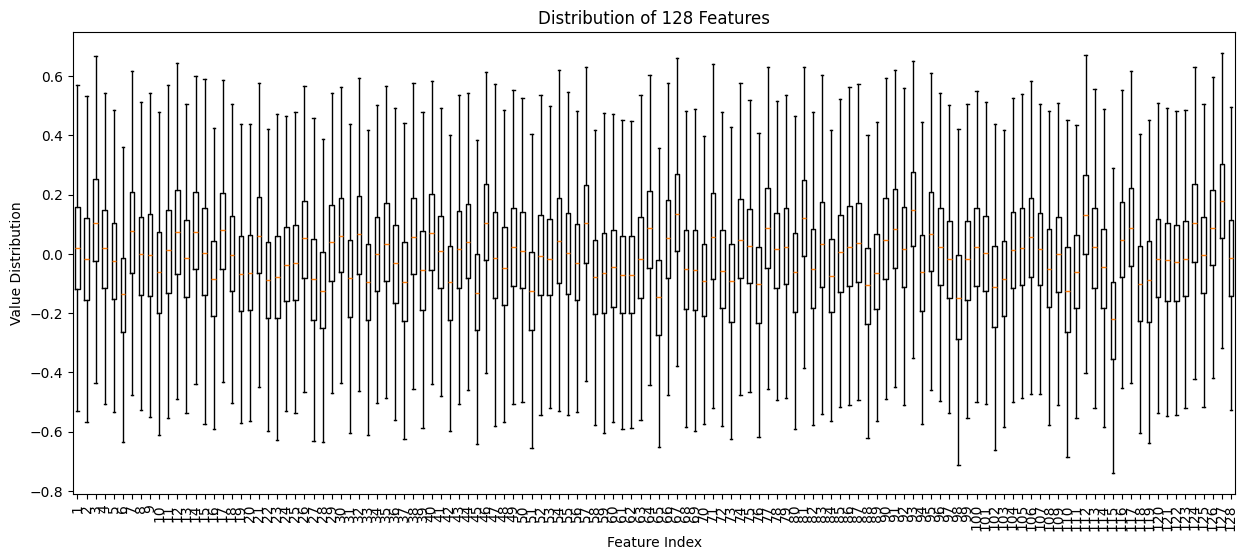

In [19]:
# Set up the figure and axes
plt.figure(figsize=(15, 6))
plt.boxplot(X_outlier, vert=True, showfliers=False)  # Box plot of all features
plt.xlabel("Feature Index")
plt.ylabel("Value Distribution")
plt.title("Distribution of 128 Features")
plt.xticks(rotation=90)

# Show the plot
plt.show()

### OOC SVM

#### linear OOC SVM

In [ ]:

prs = []
recalls = []
aucs = []
nu = 0.7

for i in range(1):

    X_pos_train, X_pos_test = train_test_split(X_pos, test_size=0.2, random_state=42)
    # X_pos_train, X_pos_test = train_test_split(X_pos, test_size=0.2)
    X_test = np.vstack((X_pos_test, X_outlier))
    y_test = np.array([1] * len(X_pos_test) + [-1] * len(X_outlier))

    # Standardize the data
    # scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # X_pos_train = scaler.fit_transform(X_pos_train)


    # oc_svm = svm.OneClassSVM(kernel='linear',nu=nu)
    # oc_svm = svm.OneClassSVM(kernel='poly', degree=3, nu=nu)
    oc_svm = svm.OneClassSVM(kernel='rbf', gamma = 0.5, nu=nu)
    oc_svm.fit(X_pos_train)

    y_pred = oc_svm.predict(X_test)
    precision = metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = metrics.recall_score(y_test, y_pred, pos_label=1)
    # print(precision,recall)

    scores = oc_svm.score_samples(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores, pos_label=1)
    auc = metrics.roc_auc_score(y_test, scores)
    prs.append(precision)
    recalls.append(recall)
    aucs.append(auc)

print(get_mean_std_numpy(prs),get_mean_std_numpy(recalls),get_mean_std_numpy(aucs))

# # Plot the ROC curve
# plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title(f"ROC Curve of linear OOC SVM, nu={nu}")

# plt.legend()

# plt.text(0.6, 0.2, f"Precision: {precision:.4f}", fontsize=10, color='blue')
# plt.text(0.6, 0.1, f"Recall: {recall:.4f}", fontsize=10, color='blue')

# plt.show()

(0.018, nan) (0.285, nan) (0.676, nan)


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### cross validation

In [10]:
from sklearn.model_selection import KFold
from sklearn.svm import OneClassSVM
from sklearn import metrics
from sklearn.model_selection import ParameterGrid, train_test_split

############# oocsvm

def occ_cross_validation(fold,X_pos,X_outlier,parameters):
    # Split X_pos into 5 folds
    kf = KFold(n_splits=fold, shuffle=True)
    splits = list(kf.split(X_pos))
    auc_folds = []
    # Prepare train and test sets
    for train_idx, test_idx in splits:
        # Combine outliers with one of the folds to form the test set
        X_test = np.vstack((X_pos[test_idx], X_outlier))
        # Use remaining folds as the training set
        X_train = X_pos[train_idx]

        # Train One-Class SVM on the training set
        ocsvm = OneClassSVM(**parameters)
        ocsvm.fit(X_train)

        # Create test labels
        y_test = np.array([1] * len(X_pos[test_idx]) + [-1] * len(X_outlier))

        # # Predict on the test set
        # y_pred = ocsvm.predict(X_test)
        # # Calculate precision and recall for the positive class (label 1)
        # precision = metrics.precision_score(y_test, y_pred, pos_label=1)
        # recall = metrics.recall_score(y_test, y_pred, pos_label=1)

        scores = ocsvm.score_samples(X_test)

        # Compute ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, scores, pos_label=1)
        auc = metrics.roc_auc_score(y_test, scores)
        auc_folds.append(auc)
        # # Plot the ROC curve
        # plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.title("ROC Curve")
        # plt.legend()
        # plt.show()
    return sum(auc_folds) / len(auc_folds)

# One-Class SVM parem
param_grid = {
    'nu': [0.01, 0.1,0.3,0.5],
    'kernel': ['rbf','linear'],
    'gamma': ['auto', 'scale',0.1,1,10,100]
}

X_pos_train, X_pos_test = train_test_split(X_pos, test_size=0.2, random_state=42)
X_out_train, X_out_test = train_test_split(X_outlier, test_size=0.2, random_state=42)

best_auc = -np.inf 
best_params = None 
records = dict()

for g in ParameterGrid(param_grid):
    auc = occ_cross_validation(5, X_pos_train, X_out_train, g)
    records[tuple(g.items())] = ['auc', auc]
    if auc > best_auc:
        best_auc = auc
        best_params = g  # Update the best parameters

print(f"Best parameters: {best_params}")
print(f"Best AUC: {best_auc}")


Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.5}
Best AUC: 0.6043027140883108


In [11]:
record_df = pd.DataFrame(records.items(), columns=['param', 'auc'])

record_df[['gamma', 'kernel', 'nu']] = record_df['param'].apply(lambda x: pd.Series(dict(x)))

# Extract AUC values from list to numeric
record_df['auc'] = record_df['auc'].apply(lambda x: x[1])

# Drop the original 'param' column
record_df = record_df.drop(columns=['param'])
record_df.sort_values(by='auc', ascending=False)

,auc,gamma,kernel,nu
11,0.604303,scale,rbf,0.50
19,0.603869,0.1,rbf,0.50
1,0.603283,auto,rbf,0.10
3,0.602995,auto,rbf,0.50
17,0.602834,0.1,rbf,0.10
10,0.602674,scale,rbf,0.30
16,0.602579,0.1,rbf,0.01
9,0.602521,scale,rbf,0.10
8,0.602494,scale,rbf,0.01
18,0.602265,0.1,rbf,0.30


In [12]:
from sklearn.decomposition import PCA
def test_ooc(ga, ke, nu,pca_plot):
    ocsvm = OneClassSVM(gamma=ga, kernel=ke, nu=nu)
    ocsvm.fit(X_pos_train)
    X_test = np.vstack((X_pos_test,X_out_test))
    y_test = np.array([1] * len(X_pos_test) + [-1] * len(X_out_test))
    y_pred = ocsvm.predict(X_test)

    # Calculate precision and recall for the positive class (label 1)
    precision = metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = metrics.recall_score(y_test, y_pred, pos_label=1)

    print(precision, recall)

    scores = ocsvm.score_samples(X_test)
    # Compute ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores, pos_label=1)
    auc = metrics.roc_auc_score(y_test, scores)

    

    # # Plot the ROC curve
    # plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("ROC Curve")
    # plt.legend()
    # plt.show()

    if pca_plot is True:
        # Reduce dimensions for visualization using PCA
        pca = PCA(n_components=2)
        X_train_2D = pca.fit_transform(X_pos_train)
        X_test_2D = pca.transform(X_test)

        TP_samples = X_test_2D[(y_test == 1) & (y_pred == 1)]
        FP_samples = X_test_2D[(y_test == -1) & (y_pred == 1)]
        TN_samples = X_test_2D[(y_test == -1) & (y_pred == -1)]
        FN_samples = X_test_2D[(y_test == 1) & (y_pred == -1)]

        # Plot the decision boundary and points
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c='lightblue', marker='o', label='Training Data')
        plt.scatter(TP_samples[:, 0], TP_samples[:, 1], c='blue', marker='x', label='TP Data')

        plt.scatter(TN_samples[:, 0], TN_samples[:, 1], c='#FFCCCB', marker='x', label='TN Data',alpha=0.3)


        # Add labels and legend
        plt.title('OCC SVM Decision Boundary with Inliers and Outliers')
        plt.legend()
        plt.show()
    return fpr,tpr,auc

0.06156156156156156 0.5774647887323944
0.06151537884471118 0.5774647887323944
0.040325203252032524 0.8732394366197183


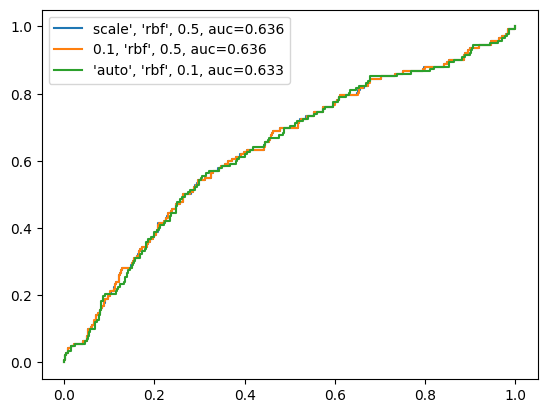

In [13]:
plt.figure(0).clf()

fpr, tpr, auc = test_ooc('scale', 'rbf', 0.5, pca_plot=False)
plt.plot(fpr,tpr,label="scale', 'rbf', 0.5, auc="+str(round(auc,3)))

fpr, tpr, auc = test_ooc(0.1, 'rbf', 0.5, pca_plot=False)
plt.plot(fpr,tpr,label="0.1, 'rbf', 0.5, auc="+str(round(auc,3)))

fpr, tpr, auc = test_ooc('auto', 'rbf', 0.1, pca_plot=False)

plt.plot(fpr,tpr,label="'auto', 'rbf', 0.1, auc="+str(round(auc,3)))

plt.legend(loc=0)

0.040325203252032524 0.8732394366197183


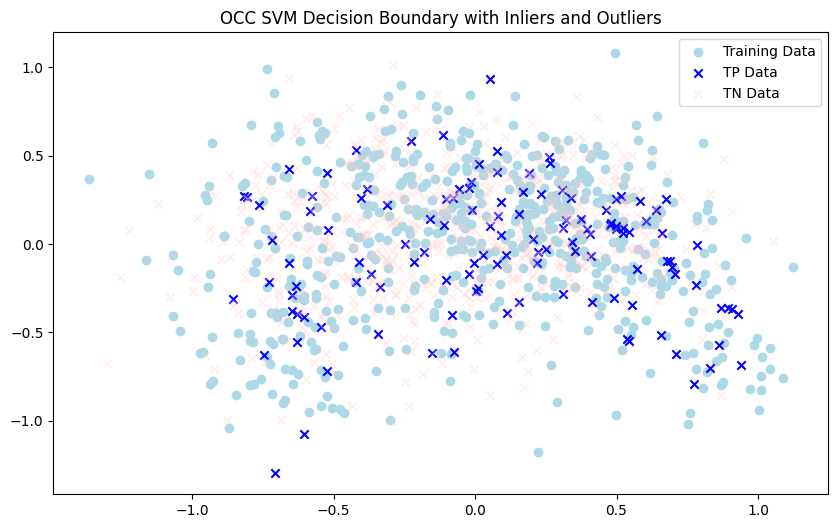

(array([0.00000000e+00, 2.76778301e-04, 2.76778301e-04, 5.53556601e-04,
        5.53556601e-04, 2.49100471e-03, 2.49100471e-03, 3.32133961e-03,
        3.32133961e-03, 7.19623582e-03, 7.19623582e-03, 1.54995848e-02,
        1.54995848e-02, 2.49100471e-02, 2.49100471e-02, 4.53916413e-02,
        4.53916413e-02, 5.03736507e-02, 5.03736507e-02, 5.20343205e-02,
        5.20343205e-02, 5.39717686e-02, 5.39717686e-02, 5.56324384e-02,
        5.56324384e-02, 5.61859950e-02, 5.61859950e-02, 6.80874619e-02,
        6.80874619e-02, 6.86410185e-02, 6.86410185e-02, 7.30694714e-02,
        7.30694714e-02, 7.69443676e-02, 7.69443676e-02, 7.72211459e-02,
        7.72211459e-02, 7.94353723e-02, 7.94353723e-02, 8.08192638e-02,
        8.08192638e-02, 8.13728204e-02, 8.13728204e-02, 8.24799336e-02,
        8.24799336e-02, 8.52477166e-02, 8.52477166e-02, 8.58012732e-02,
        8.58012732e-02, 9.02297260e-02, 9.02297260e-02, 1.14862995e-01,
        1.14862995e-01, 1.17077221e-01, 1.17077221e-01, 1.192914

In [14]:
test_ooc('auto', 'rbf', 0.1,pca_plot=True)

0.06156156156156156 0.5774647887323944


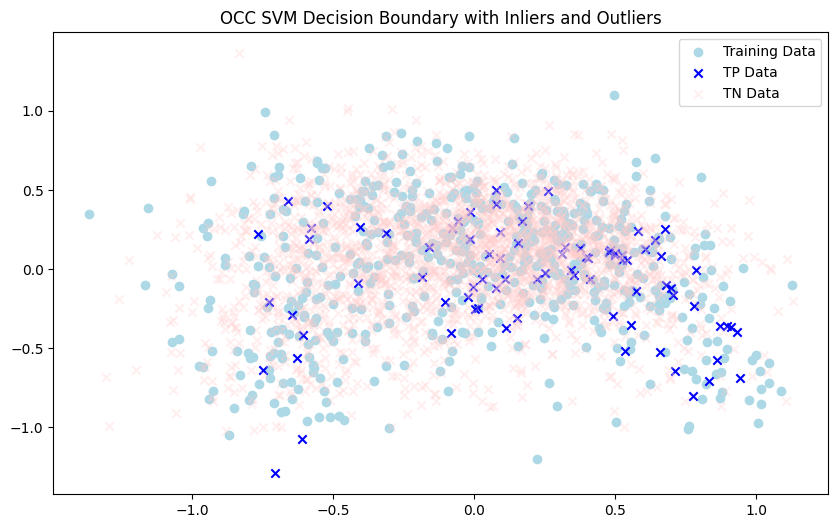

(array([0.00000000e+00, 2.76778301e-04, 2.76778301e-04, 8.30334902e-04,
        8.30334902e-04, 1.93744810e-03, 1.93744810e-03, 3.04456131e-03,
        3.04456131e-03, 8.58012732e-03, 8.58012732e-03, 1.46692499e-02,
        1.46692499e-02, 2.21422640e-02, 2.21422640e-02, 4.12399668e-02,
        4.12399668e-02, 5.06504290e-02, 5.06504290e-02, 5.14807639e-02,
        5.14807639e-02, 5.23110988e-02, 5.23110988e-02, 5.25878771e-02,
        5.25878771e-02, 5.34182120e-02, 5.34182120e-02, 5.97841129e-02,
        5.97841129e-02, 6.25518959e-02, 6.25518959e-02, 6.55964572e-02,
        6.55964572e-02, 6.72571270e-02, 6.72571270e-02, 6.94713534e-02,
        6.94713534e-02, 6.97481317e-02, 6.97481317e-02, 7.38998063e-02,
        7.38998063e-02, 7.99889289e-02, 7.99889289e-02, 8.24799336e-02,
        8.24799336e-02, 8.27567119e-02, 8.27567119e-02, 8.91226128e-02,
        8.91226128e-02, 8.93993911e-02, 8.93993911e-02, 8.96761694e-02,
        8.96761694e-02, 9.79795184e-02, 9.79795184e-02, 1.013008

In [15]:
test_ooc('scale', 'rbf', 0.5,True)

0.05614230127848805 0.7112676056338029


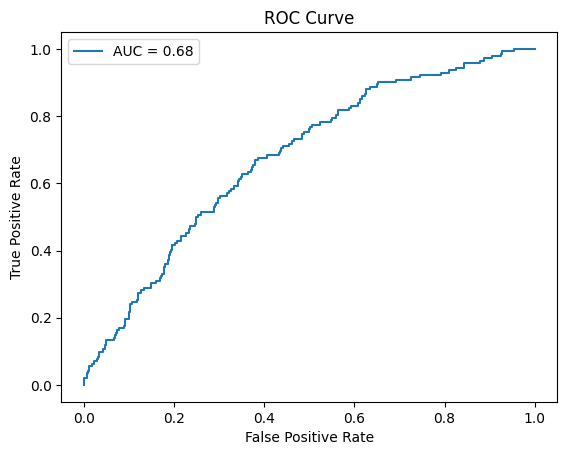

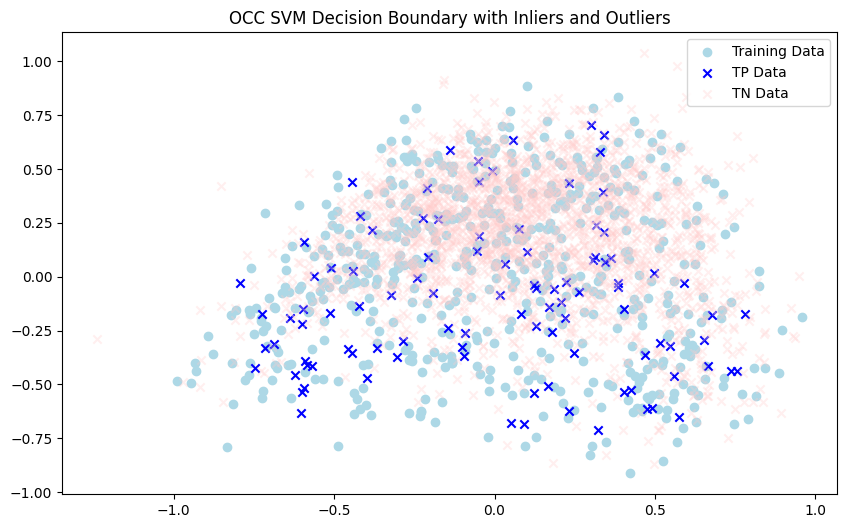

In [37]:
test_ooc('scale', 'rbf', 0.3,True)

0.04685157421289355 0.8802816901408451


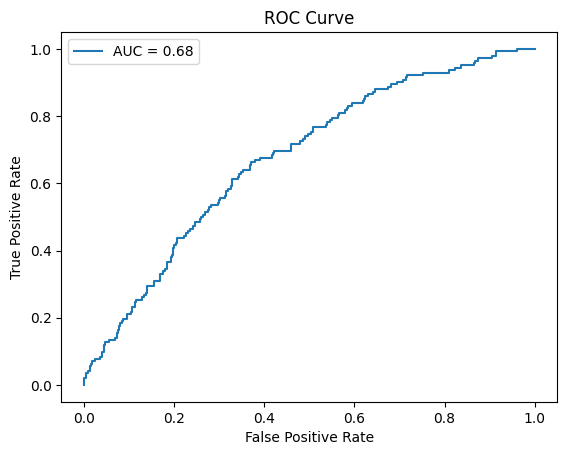

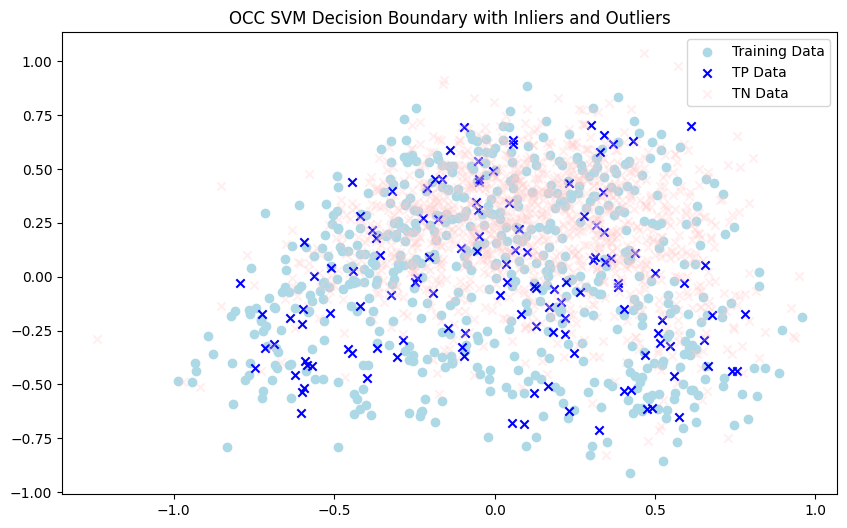

In [46]:
test_ooc('scale', 'rbf', 0.01,True)

### nested cross validation

In [39]:
#####nested oocsvm

fold = 3
# List to store the scores for each fold
nested_scores = []
records = {}

kf = KFold(n_splits=fold, shuffle=True)
pos_splits = list(kf.split(X_pos))
outlier_splits = list(kf.split(X_outlier))
auc_folds = []

# One-Class SVM parameters
param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'kernel': ['rbf'],
    'gamma': ['auto', 'scale']
}

for (train_pos, test_pos), (train_outlier, test_outlier) in zip(pos_splits, outlier_splits):
    # Combine positive and outlier data for testing
    X_test_out = np.vstack((X_pos[test_pos], X_outlier[test_outlier]))
    
    best_auc = -np.inf
    best_params = None
    best_model = None

    # Iterate over the parameter grid
    for g in ParameterGrid(param_grid):
        auc = occ_cross_validation(5, X_pos[train_pos], X_outlier[train_outlier], g)
        records[tuple(g.items())] = ['auc', auc]
        
        # Track the best model based on AUC
        if auc > best_auc:
            best_auc = auc
            best_params = g
            # Train the best model with the selected parameters
            best_model = OneClassSVM(**g)
            best_model.fit(np.vstack((X_pos[train_pos], X_outlier[train_outlier])))  # Combine positive and outliers for training

    y_test_out = np.array([1] * len(X_pos[test_pos]) + [-1] * len(X_outlier[test_outlier]))
    scores = best_model.score_samples(X_test_out)

    # Compute ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test_out, scores, pos_label=1)
    auc = metrics.roc_auc_score(y_test_out, scores)

    nested_scores.append(auc)

# Calculate the mean score across all folds
mean_score = np.mean(nested_scores)
print(f"Nested CV Mean Accuracy: {mean_score:.4f}")

Nested CV Mean Accuracy: 0.6572


## random negative svm

In [16]:


# Combine data

X_pos_train, X_pos_test = train_test_split(X_pos, test_size=0.2, random_state=42)
X_out_train, X_out_test = train_test_split(X_outlier, test_size=0.2, random_state=42)

X_test = np.vstack((X_pos_test,X_out_test))
y_test = np.array([1] * len(X_pos_test) + [0] * len(X_out_test))

X_neg_train = X_out_train[np.random.choice(X_out_train.shape[0], X_pos_train.shape[0], replace=False)]
X_train = np.vstack((X_pos_train,X_neg_train))

y_train = np.array([1] * len(X_pos_train) + [0] * len(X_neg_train))


# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto',0.1,1,10,100]
}

# Initialize SVM with probability estimates
svm = SVC(probability=True)

# Perform Grid Search with Cross-Validation using AUC as the scoring metric
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters and best cross-validation AUC score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation AUC:", grid_search.best_score_)

# Print all cross-validation results
print("\nAll cross-validation results:")
cv_results = grid_search.cv_results_
records_svm = pd.DataFrame({
    'auc': cv_results['mean_test_score'],
    'Params': cv_results['params']
})
records_svm.sort_values(by='auc', ascending=False)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation AUC: 0.6211979626998423

All cross-validation results:


,auc,Params
1,0.621198,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}"
5,0.621072,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}"
13,0.607258,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"
17,0.607161,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}"
7,0.602861,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}"
19,0.601944,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
43,0.600296,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
31,0.600296,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}"
15,0.595547,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}"
3,0.595042,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}"


In [17]:
from sklearn import metrics

def test_svm(ga, ke, c):
    svm = SVC(gamma=ga, kernel=ke, C=c)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)

    # Calculate precision and recall for the positive class (label 1)
    precision = metrics.precision_score(y_test, y_pred, pos_label=1)
    recall = metrics.recall_score(y_test, y_pred, pos_label=1)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    scores = svm.decision_function(X_test)
    # Compute ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores, pos_label=1)
    auc = metrics.roc_auc_score(y_test, scores)

    # # Plot the ROC curve
    # plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    # plt.xlabel("False Positive Rate")
    # plt.ylabel("True Positive Rate")
    # plt.title("ROC Curve")
    # plt.legend()
    # plt.show()
    return fpr, tpr, auc

Precision: 0.07, Recall: 0.53
Confusion Matrix:
[[2804  979]
 [  67   75]]


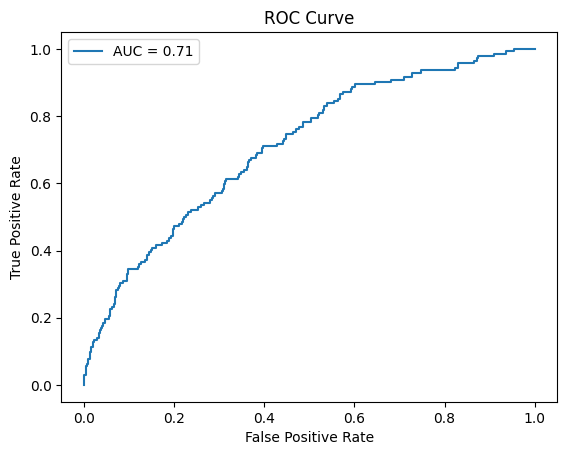

In [35]:
test_svm('scale', 'rbf', 0.1)

Precision: 0.07, Recall: 0.72
Confusion Matrix:
[[2369 1414]
 [  40  102]]


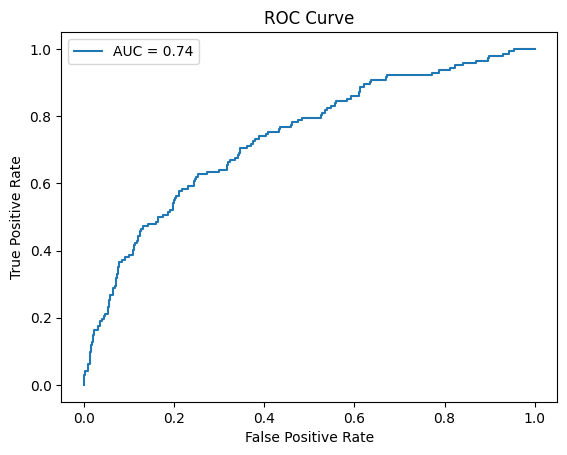

In [36]:
test_svm('scale', 'rbf', 1)

Precision: 0.08, Recall: 0.51
Confusion Matrix:
[[2824  789]
 [  70   72]]
Precision: 0.08, Recall: 0.51
Confusion Matrix:
[[2776  837]
 [  69   73]]
Precision: 0.06, Recall: 0.63
Confusion Matrix:
[[2185 1428]
 [  52   90]]


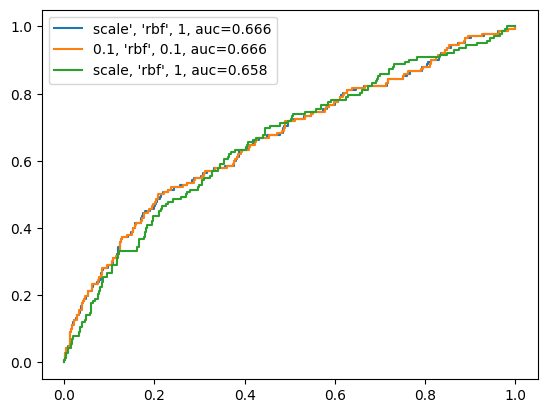

In [18]:
plt.figure(0).clf()

# fpr, tpr, auc = test_ooc(1, 'rbf', 0.3, pca_plot=False)
fpr, tpr, auc = test_svm('scale', 'rbf', 0.1)
plt.plot(fpr,tpr,label="scale', 'rbf', 1, auc="+str(round(auc,3)))

# fpr, tpr, auc = test_ooc(1, 'rbf', 0.01, pca_plot=False)
fpr, tpr, auc = test_svm(0.1, 'rbf', 0.1)
plt.plot(fpr,tpr,label="0.1, 'rbf', 0.1, auc="+str(round(auc,3)))

# fpr, tpr, auc = test_ooc('scale', 'rbf', 0.01, pca_plot=False)
# plt.plot(fpr,tpr,label="1, 'rbf', 0.01, auc="+str(round(auc,3)))
fpr, tpr, auc = test_svm('scale', 'rbf', 1)
plt.plot(fpr,tpr,label="scale, 'rbf', 1, auc="+str(round(auc,3)))

plt.legend(loc=0)

### nested svm

In [65]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer

# Combine data
X = np.vstack((X_pos, X_outlier))
y = np.array([1] * len(X_pos) + [0] * len(X_outlier))

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Define the SVM model
svm = SVC(probability=True)

# Create a GridSearchCV for the inner loop
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='roc_auc', cv=inner_cv)

# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform nested cross-validation
auc_scores = cross_val_score(grid_search, X, y, cv=outer_cv, scoring=make_scorer(roc_auc_score, needs_proba=True))

# Print the results
print("Nested CV AUC scores for y=1 samples:", auc_scores)
print("Mean AUC score:", np.mean(auc_scores))


/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/inspect.py", line 3195, in

KeyboardInterrupt: 

# pseudo labeling

In [36]:
# get data, split to train and test

X_pos_train, X_pos_test = train_test_split(X_pos, test_size=0.2, random_state=42)
X_out_train, X_out_test = train_test_split(X_outlier, test_size=0.2, random_state=42)

X_test = np.vstack((X_pos_test,X_out_test))
y_test = np.array([1] * len(X_pos_test) + [0] * len(X_out_test))

X_train = np.vstack((X_pos_train,X_out_train))
y_train = np.array([1] * len(X_pos_train) + [0] * len(X_out_train))

In [37]:
# Calculate statistics
max_values = np.max(X_train, axis=0)
min_values = np.min(X_train, axis=0)
mean_values = np.mean(X_train, axis=0)
variance_values = np.var(X_train, axis=0)

# Print results
for i in range(X_train.shape[1]):
    print(f"Feature {i}:")
    print(f"  Max: {max_values[i]:.4f}")
    print(f"  Min: {min_values[i]:.4f}")
    print(f"  Average: {mean_values[i]:.4f}")
    print(f"  Variance: {variance_values[i]:.4f}")
    print()


Feature 0:
  Max: 1.0064
  Min: -0.9648
  Average: 0.0149
  Variance: 0.0457

Feature 1:
  Max: 0.9286
  Min: -0.9296
  Average: -0.0179
  Variance: 0.0436

Feature 2:
  Max: 1.1133
  Min: -0.5723
  Average: 0.1199
  Variance: 0.0423

Feature 3:
  Max: 0.9528
  Min: -0.9077
  Average: 0.0168
  Variance: 0.0409

Feature 4:
  Max: 0.7945
  Min: -0.9053
  Average: -0.0218
  Variance: 0.0390

Feature 5:
  Max: 0.7254
  Min: -1.1847
  Average: -0.1383
  Variance: 0.0378

Feature 6:
  Max: 1.2241
  Min: -0.9394
  Average: 0.0665
  Variance: 0.0443

Feature 7:
  Max: 0.8348
  Min: -1.0396
  Average: -0.0075
  Variance: 0.0395

Feature 8:
  Max: 0.8939
  Min: -1.1171
  Average: -0.0040
  Variance: 0.0444

Feature 9:
  Max: 0.8163
  Min: -1.0031
  Average: -0.0639
  Variance: 0.0430

Feature 10:
  Max: 0.9346
  Min: -1.0164
  Average: 0.0041
  Variance: 0.0448

Feature 11:
  Max: 0.8188
  Min: -0.9375
  Average: 0.0725
  Variance: 0.0453

Feature 12:
  Max: 0.7748
  Min: -1.0099
  Average: -0.0

In [38]:
# apply clustering (k-means, density-based, hieracial clustering) to train set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize the data
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X_train)
X_scaled = X_train

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)



### k means and dbscan

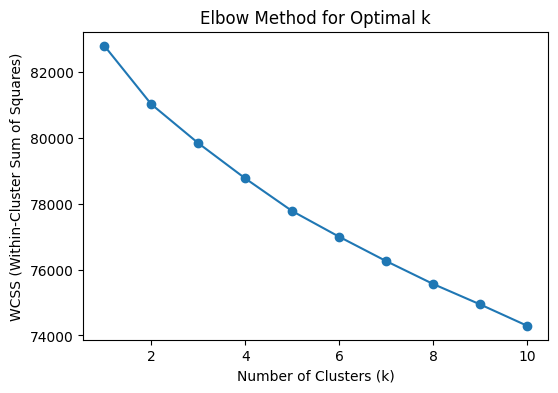

In [101]:
# Try different values of k
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Sum of squared distances to cluster center

# Plot the Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

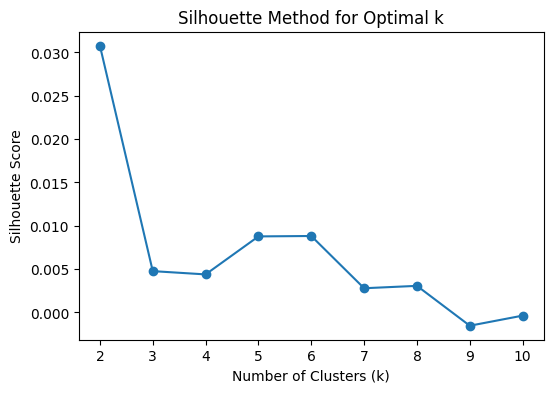

In [102]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()


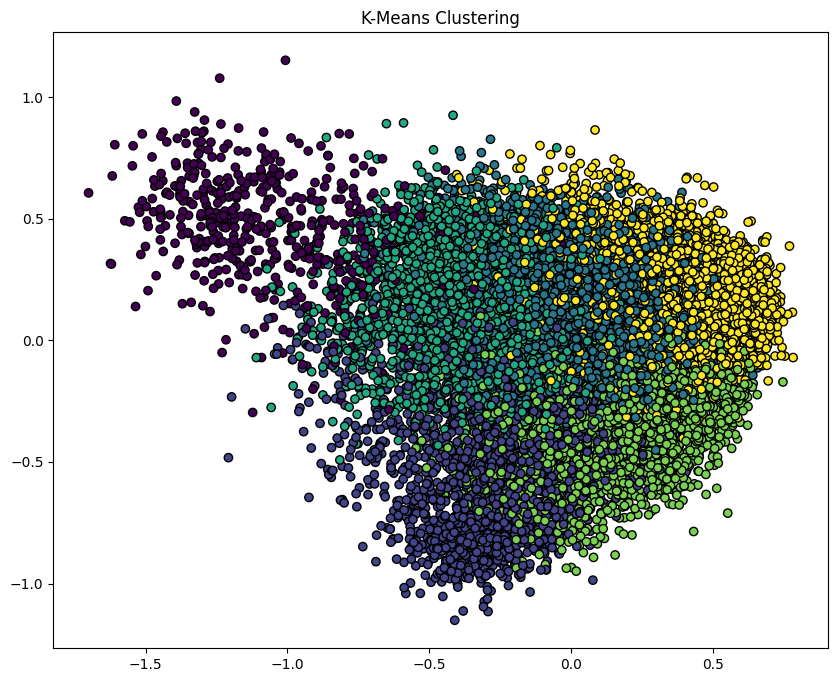

In [103]:

# Apply K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k')
plt.title("K-Means Clustering")
plt.show()

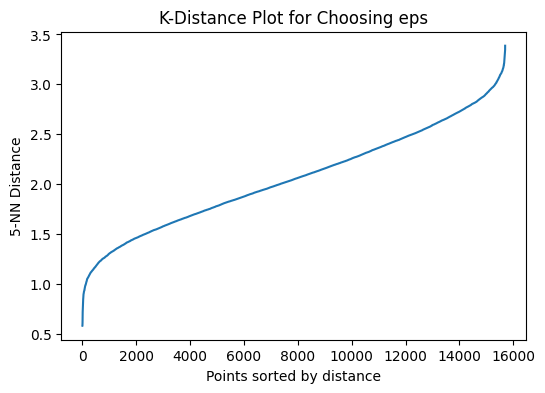

In [104]:
from sklearn.neighbors import NearestNeighbors

# Define min_samples (rule of thumb: min_samples ≈ 2 * n_features)
min_samples = 5  # Adjust as needed

# Compute k-nearest neighbors distances
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort and plot k-distance graph
sorted_distances = np.sort(distances[:, -1])  # Take the max distance for each point
plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN Distance")
plt.title("K-Distance Plot for Choosing eps")
plt.show()


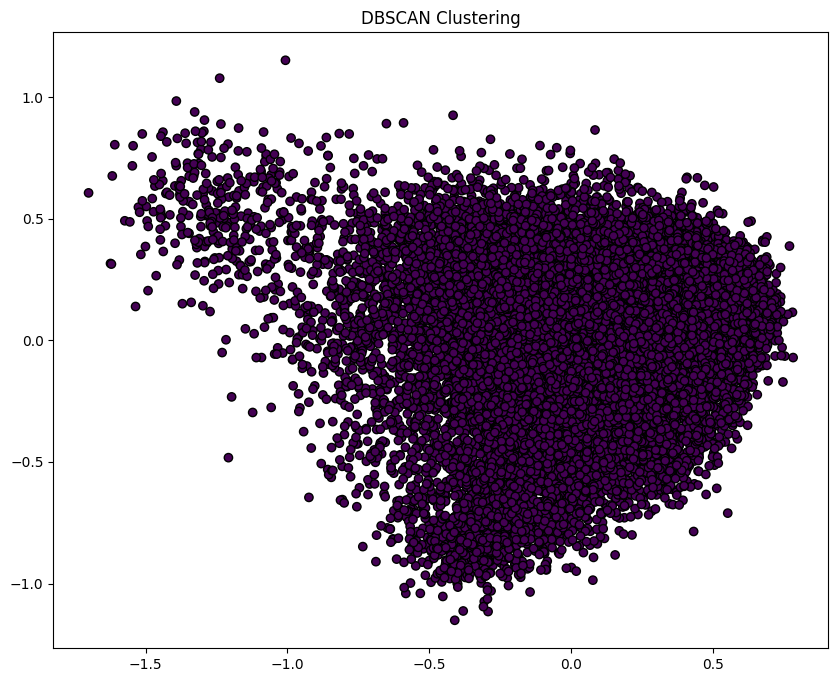

In [105]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', edgecolors='k')
plt.title("DBSCAN Clustering")
plt.show()

### hierarchical clustering

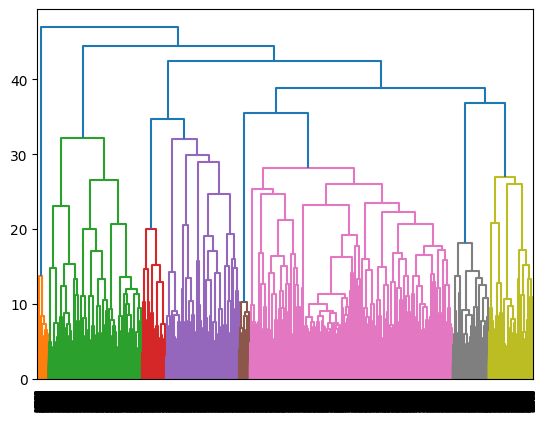

In [39]:
# Apply Hierarchical Clustering

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster, linkage

def getLinkageMat(model):
    children = model.children_
    cs = np.zeros(len(children))
    N = len(model.labels_)
    for i,child in enumerate(children):
        count = 0
        for idx in child:
            count += 1 if idx < N else cs[idx - N]
        cs[i] = count
    return np.column_stack([children, model.distances_, cs])


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_train)
mat = getLinkageMat(model)
test = dendrogram(mat)
plt.show()


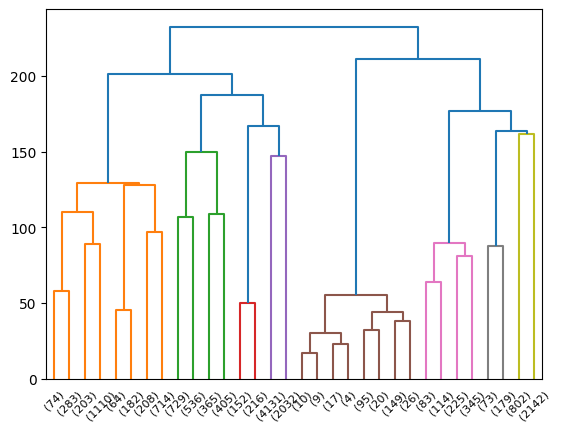

In [51]:
test = dendrogram(mat, truncate_mode='level', p=4)
plt.show()

In [40]:
n_clusters = 5  # Change based on how many clusters you see in the dendrogram
labels = fcluster(mat, n_clusters, criterion='maxclust')

# Print or return the labels
print(set(labels))  # Array of cluster labels


{1, 2, 3, 4, 5}


In [55]:
10**2

100

In [65]:
def getLinkageMat(model):
    children = model.children_
    cs = np.zeros(len(children))
    N = len(model.labels_)
    for i,child in enumerate(children):
        count = 0
        for idx in child:
            count += 1 if idx < N else cs[idx - N]
        cs[i] = count
    return np.column_stack([children, model.distances_, cs])

def calculate_proportion(hierarchical_labels,y_train):
    proportion = []
    unique_clusters = np.unique(hierarchical_labels)
    # Total number of samples with label 1
    total_y1 = np.sum(y_train == 1)
    # print('total positive',total_y1)
    for c in unique_clusters:
        # Indices of samples in the current cluster
        cluster_indices = np.where(hierarchical_labels == c)[0]
        
        # Number of samples with label 1 in this cluster
        cluster_y1 = np.sum(y_train[cluster_indices] == 1)
        
        # Calculate A_i using the corrected formula
        # A_i = np.sqrt(len(cluster_indices)) * (1 - (cluster_y1 / total_y1))**2
        A_i = 2*len(cluster_indices)/len(y_train) - cluster_y1 / total_y1
        proportion.append(A_i)

        #########################################
        #########################################
        # print('pos num:',100*len(cluster_indices)/len(y_train),100*cluster_y1/np.sum(y_train==1))
        # print('random neg num:',c,int((len(cluster_indices)/len(y_train))*np.sum(y_train==1)))
        #########################################
        #########################################
    return proportion

def cluster_negative_sampling(hierarchical_labels,y_train,proportion,neg_size):
    neg_cluster = []
    all_sampled_negatives = []
    unique_clusters = np.unique(hierarchical_labels)
    total_proportion = sum(proportion)
    if total_proportion == 0:
        raise ValueError("Sum of proportions is zero. Check the 'proportion' calculation.")

    for index, c in enumerate(unique_clusters):
        A_i = proportion[index]
        neg_i = round((A_i / total_proportion) * neg_size)
        #########################################
        #########################################
        print('select neg num:',index+1,neg_i)
        #########################################
        #########################################
        cluster_indices = np.where(hierarchical_labels == c)[0]
        negative_indices = np.array(cluster_indices)[y_train[cluster_indices] == 0]
        # Check if there are enough negative samples to draw from
        if len(negative_indices) == 0:
            continue  
        elif neg_i > len(negative_indices):
            neg_i = len(negative_indices)  # Adjust to the maximum available
        # Sample negative indices without replacement
        sampled_indices = np.random.choice(negative_indices, size=neg_i, replace=False)
        # Store the sampled indices and the count
        all_sampled_negatives.extend(sampled_indices)
        neg_cluster.append(neg_i)

    return all_sampled_negatives



In [53]:
X_train.shape,y_train.shape,np.sum(y_train==1)

((15696, 128), (15696,), 116)

In [66]:
hierarchical_labels = labels
neg_num = np.sum(y_train==1)
# sample negatives
proportion = calculate_proportion(hierarchical_labels,y_train)
all_sampled_negatives = cluster_negative_sampling(hierarchical_labels,y_train,proportion,neg_num)

select neg num: 1 5
select neg num: 2 22
select neg num: 3 26
select neg num: 4 62
select neg num: 5 0


In [53]:
import numpy as np

unique_clusters = np.unique(labels)
random_distribution = np.sum(y_train == 1) / len(y_train)
print(f"Random distribution of positive for each cluster should be: {random_distribution * 100:.2f}%")

negative_sample_summary = []

for c in unique_clusters:
    cluster_indices = np.where(labels == c)[0]
    num_y1 = np.sum(y_train[cluster_indices] == 1)
    percentage_y1 = (num_y1 / len(cluster_indices)) * 100

    # Compute the number of negative samples to collect
    negative_sample_num = int(2 * random_distribution * len(cluster_indices) - num_y1)
    
    print(f"Cluster {c} (size {len(cluster_indices)}): {num_y1} instances of positive samples ({percentage_y1:.2f}%)")
    
    negative_sample_summary.append({"Cluster": c, "NegativeSamplesNeeded": negative_sample_num})


Random distribution of positive for each cluster should be: 3.61%
Cluster 1 (size 2838): 91 instances of positive samples (3.21%)
Cluster 2 (size 2035): 100 instances of positive samples (4.91%)
Cluster 3 (size 6531): 195 instances of positive samples (2.99%)
Cluster 4 (size 330): 3 instances of positive samples (0.91%)
Cluster 5 (size 3963): 178 instances of positive samples (4.49%)


In [57]:
prs = []
recalls = []
aucs = []

def get_mean_std_numpy(lst):
    mean = np.mean(lst)
    std_dev = np.std(lst, ddof=1)  # Sample standard deviation (N-1)
    return round(mean,3), round(std_dev,3)

for i in range(5):
    all_sampled_negatives = [] 
    for index, c in enumerate(unique_clusters):
        negative_sample_num = negative_sample_summary[index]['NegativeSamplesNeeded']
        cluster_indices = np.where(labels == c)[0]
        negative_indices = np.array(cluster_indices)[y_train[cluster_indices] == 0]
        sampled_indices = np.random.choice(negative_indices, size=negative_sample_num, replace=False)
        all_sampled_negatives.extend(sampled_indices)

    # svm train and test (no cv for now)
    X_train_balanced = np.vstack((X_pos_train,X_train[all_sampled_negatives]))
    y_train_balanced = np.array([1] * len(X_pos_train) + [0] * len(X_train[all_sampled_negatives]))

    svm_model = SVC(gamma=0.5, kernel='rbf', C=0.7, probability=True)  # Enable probability for AUROC
    # svm_model = SVC(kernel='linear', C=0.7, probability=True) 
    # svm_model = SVC(kernel='poly', degree=3,gamma = 0.5,C=0.7, probability=True)
    svm_model.fit(X_train_balanced, y_train_balanced)

    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class

    # Compute recall and precision
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    prs.append(precision)
    recalls.append(recall)
    aucs.append(roc_auc)

print(get_mean_std_numpy(prs),get_mean_std_numpy(recalls),get_mean_std_numpy(aucs))

(0.036, 0.0) (1.0, 0.0) (0.414, 0.012)


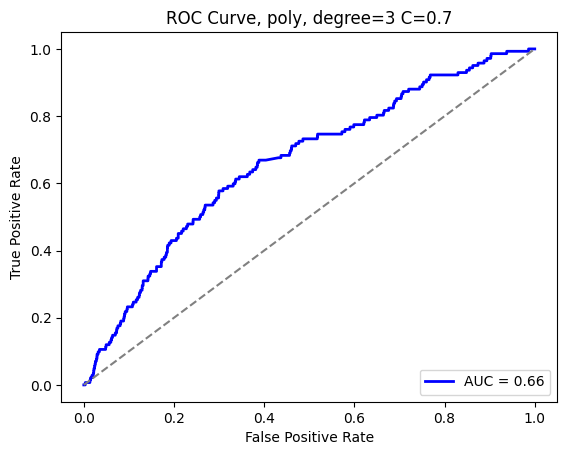

(0.7465, 0.0479, 0.6629482153295134)

In [53]:
# Define and train the SVM model
# svm_model = SVC(gamma=0.5, kernel='rbf', C=0.7, probability=True)  # Enable probability for AUROC
# svm_model = SVC(kernel='linear', C=0.7, probability=True) 
svm_model = SVC(kernel='poly', degree=3, gamma = 0.5,C=0.7, probability=True)
svm_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class

# Compute recall and precision
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the AUROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve, poly, degree=3 C=0.7')
plt.legend(loc='lower right')
plt.show()

# Return computed metrics
round(recall,4), round(precision,4), roc_auc

In [34]:
prs = []
recalls = []
aucs = []
for i in range(5):
    ## random negative
    X_neg_train = X_out_train[np.random.choice(X_out_train.shape[0], X_pos_train.shape[0], replace=False)]
    X_train_random = np.vstack((X_pos_train,X_neg_train))

    y_train_random = np.array([1] * len(X_pos_train) + [0] * len(X_neg_train))


    # Define and train the SVM model
    svm_model = SVC(gamma=0.5, kernel='rbf', C=0.7, probability=True)  # Enable probability for AUROC
    # svm_model = SVC(kernel='linear', C=0.7, probability=True) 
    # svm_model = SVC(kernel='poly', degree=3,gamma = 0.5,C=0.7, probability=True)
    svm_model.fit(X_train_random, y_train_random)

    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class

    # Compute recall and precision
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    prs.append(precision)
    recalls.append(recall)
    aucs.append(roc_auc)

print(get_mean_std_numpy(prs),get_mean_std_numpy(recalls),get_mean_std_numpy(aucs))

# # Plot the AUROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()

# # Return computed metrics
# recall, precision, roc_auc

(0.083, 0.004) (0.476, 0.03) (0.692, 0.007)


In [62]:
from sklearn.metrics import classification_report, accuracy_score
X = np.vstack((X_pos,X_outlier))
y = np.array([1] * len(X_pos) + [0] * len(X_outlier))

x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.125, stratify=y_train_val)

classifier = SVC()
classifier.fit(x_train, y_train)

y_pred_val = classifier.predict(x_test)
test_report = classification_report(y_test, y_pred_val, output_dict=True) 
accuracy = accuracy_score(y_test, y_pred_val)
test_report,accuracy

/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/itf-fi-ml/shared/users/ziyuzh/.venv/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

({'0': {'precision': 0.9638216560509554,
   'recall': 1.0,
   'f1-score': 0.9815775817332641,
   'support': 3783.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 142.0},
  'accuracy': 0.9638216560509554,
  'macro avg': {'precision': 0.4819108280254777,
   'recall': 0.5,
   'f1-score': 0.4907887908666321,
   'support': 3925.0},
  'weighted avg': {'precision': 0.9289521846728062,
   'recall': 0.9638216560509554,
   'f1-score': 0.9460657303686467,
   'support': 3925.0}},
 0.9638216560509554)